In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


# Lab 3

Today the lab is a bit more sparse on explanation, but I think it would be nice to drill down into gaussian mixture modeling. 

Let's start with the old faithful data you used in your homework:

In [2]:
from urllib2 import urlopen
path = 'faithful.txt'
remote = urlopen('https://raw.githubusercontent.com/aidiary/PRML/master/ch9/faithful.txt')
with open('faithful.txt', 'w') as f:
    f.write(remote.read())

<IPython.core.display.Javascript object>


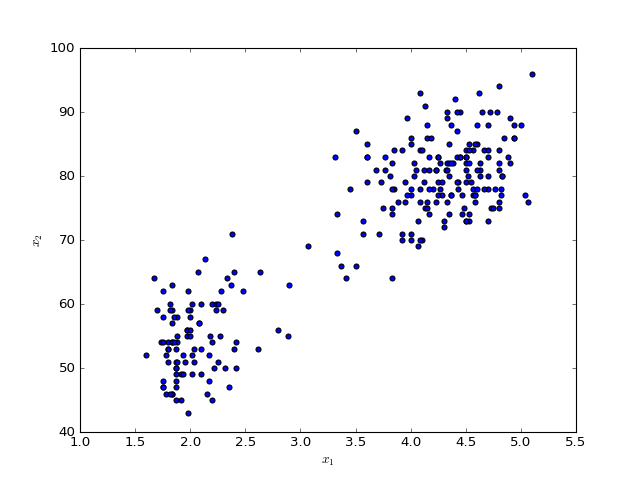

In [3]:
import pandas
df = pandas.read_csv(path, sep=' ', names=['x_1', 'x_2'])

x1 = df.loc[:,'x_1'].as_matrix()
x2 = df.loc[:,'x_2'].as_matrix()


figure()
scatter(x1, x2)
xlabel(r'$x_1$')
ylabel(r'$x_2$')
show()

Let's start with a marginal distribution

<IPython.core.display.Javascript object>


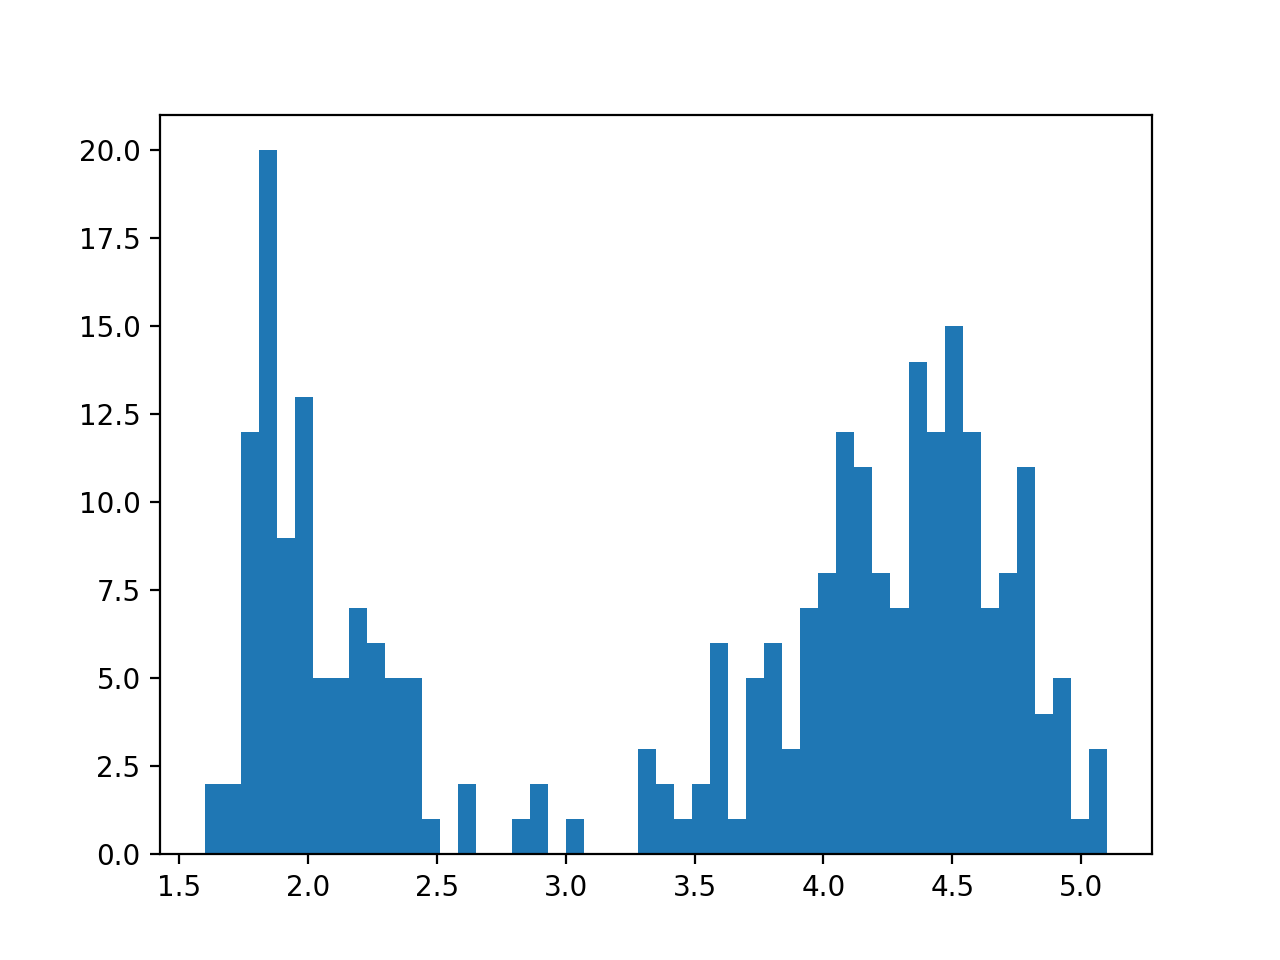

In [4]:
figure()
hist(x1, bins=50)
show()

This look's like maybe it is two Gaussians; let's focus on the one on the right. 

<IPython.core.display.Javascript object>


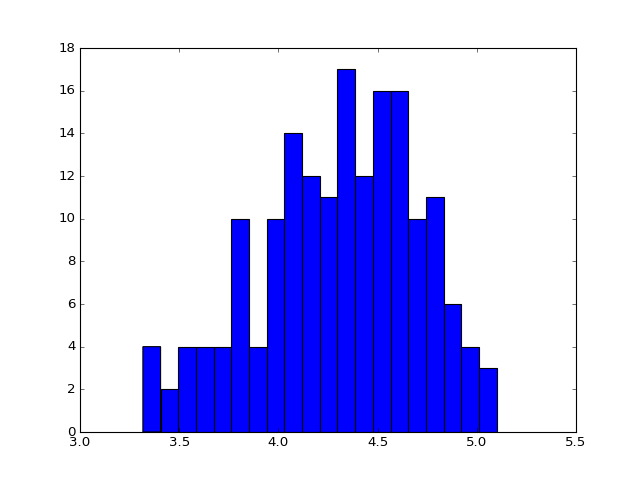

In [4]:
threshold = 3.25
x_r = x1[x1 > threshold]

figure()
hist(x_r, bins=20)
show()

In [6]:
freqs, edges = histogram(x_r, bins=20)
centers = (edges[:-1]+edges[1:])/2.

# This will be drawn on the figure above
vlines(centers, 0, freqs)
scatter(centers, freqs, color='lightgreen', zorder=2)
show()

# Challenge
Find the covariance an mean given `freqs` and `centers` only. 
Note that the input it not _samples_, it is a _sample value_ followed by a sample _wieight_

In [5]:
from scipy.stats import norm

In [6]:
def weighted_gaussian_fit(x, w):
    n = len(x)
    assert len(w) == n
    X = np.repeat(centers, freqs)
    
    return norm.fit(X)

The next cell lets you visualize the results. 

In [7]:
mu, var = weighted_gaussian_fit(centers, freqs)

x_fit = linspace(x_r.min(), x_r.max(), 100)
y_fit = (1./sqrt(2*pi*var))*exp(-((x_fit-mu)**2)/(2*var))

fig = figure()
hist(x_r, bins=20, color='grey', zorder=1)
xlabel(r'$x_r$')
ylabel(r'freq($x_r$)')

twinx()
ylabel('$N(x_r|\mu,\sigma^2)$')
tick_params('y', colors='blue')
plot(x_fit, y_fit, color='blue', zorder=2)
tight_layout()
show()

NameError: name 'centers' is not defined

# Challenge
Now, let's extend that to a multivariate (2D) gaussian

In [8]:
x1_r = x_r
x2_r = x2[x1 > threshold ]

In [9]:
from mpl_toolkits.mplot3d import Axes3D

<IPython.core.display.Javascript object>


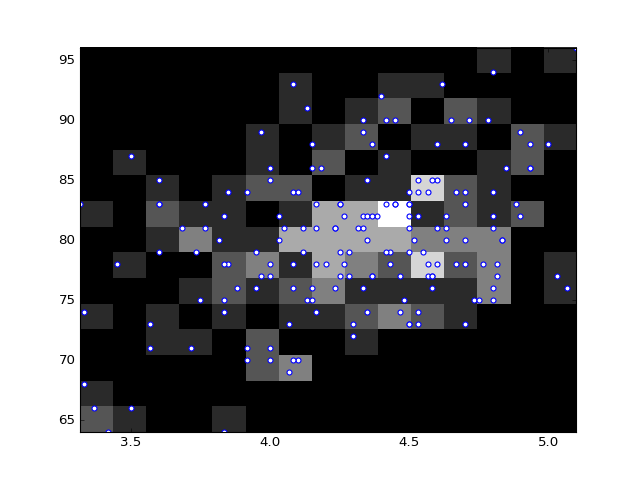

In [10]:
figure()
hist2d(x1_r, x2_r, bins=(15, 15), cmap=cm.gray)
scatter(x1_r, x2_r, edgecolor='blue', facecolor='white')
show()

In [12]:
freqs, x1_edges, x2_edges = histogram2d(x1_r, x2_r, bins=(15, 15))
x1_centers = (x1_edges[:-1] + x1_edges[1:])/2.
x2_centers = (x2_edges[:-1] + x2_edges[1:])/2.

In [13]:
x1_centers, x2_centers= meshgrid((x1_edges[:-1] + x1_edges[1:])/2., 
                                 (x2_edges[:-1] + x2_edges[1:])/2.)
x_centers = column_stack([x1_centers.flat, x2_centers.flat])
freqs = freqs.flatten()

Let's verify that we have coordinate pairs $(x_1, x_2)$ and frequencies aligned properly by visualizing the weighted points as circles of different sizes. 

Now, the challenge is to find the **2D** gaussian function that is most likely. 

In [14]:
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture

In [15]:
def weighted_mv_guassian_fit(x, w):
    
    # n = len(x)
    # assert w.shape == n
    X = np.repeat(x, w.astype(int), axis=0)
    clf = GaussianMixture(1)
    clf.fit(X)
    return (clf.means_[0], clf.covariances_.squeeze())

<IPython.core.display.Javascript object>


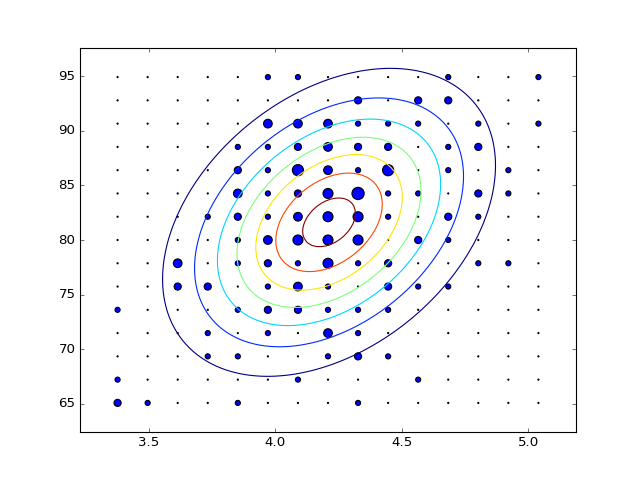

In [16]:
figure()
scatter(x_centers[:,0], x_centers[:,1], s=1+20*freqs)
mu, cov = weighted_mv_guassian_fit(x_centers, freqs)
x1_fit, x2_fit = mgrid[x1_r.min():x1_r.max():100j, x2_r.min():x2_r.max():100j]
z_fit = zeros_like(x1_fit)
for i in range(100):
    for j in range(100):
        z_fit[i,j] = multivariate_normal.pdf(array([x1_fit[i,j], x2_fit[i,j]]).T,
                                             mean=mu,
                                             cov=cov)
show()
contour(x1_fit, x2_fit, z_fit)

# Challenges multiple 1D Gaussians
Returning to the original data, we thought that $x_1$  may have been a mixture of two gaussians.

Later, we may discuss Gaussian mixture models in more depth (PRML Ch. 9). 

For now, I will introduce a simple _K means_ algorithm, with pseudocode:

<img src="http://stanford.edu/~cpiech/cs221/img/kmeansMath.png"></img>

This algorithm solves _only_ for the means of a set of Gaussian's, and it assumes that they all have the same variance. 

In [17]:
from scipy.spatial.distance import cdist

In [65]:
def kmeans(x, k):
    # This algorithm iteratively reduces the negative log likelihood
    # It stops when two iterations result in the same cluster assignments 
    converged = False
    
    # Select `k` initial 'mus', e.g. using np.random.choice?
    old_mus = array([x[idx] for idx in np.random.randint(0, len(x), 2)])
    
    # while not converged:
    for i in range(10):
        #TODO: Calculate the cluster assignments (e.g. using numpy operations and np.argmax)
        prob_x_given_mu = np.column_stack((cdist(x.reshape(len(x),-1),atleast_2d(mu)) for mu in old_mus))
        clusters = argmax(prob_x_given_mu, axis=1)
        new_mus = array([np.mean(np.take(x, where(clusters==i)[0], axis=0),axis=0) for i in range(k)])
        
        #TODO: Update the cluster centers (new_mus)
        sort(new_mus, axis=-1)
        # sort(old_mus, axis=0)
        print "old mus:", old_mus
        print "new mus:", new_mus
        converged = all(old_mus == new_mus)
        old_mus = new_mus
        # return clusters
        # print converged
        # yield new_mus, clusters
    return new_mus, clusters

In [66]:
process = kmeans(x1, 2)

old mus: [ 1.667  2.2  ]
new mus: [ 3.80947807  1.82081818]
old mus: [ 3.80947807  1.82081818]
new mus: [ 2.02016842  4.27548588]
old mus: [ 2.02016842  4.27548588]
new mus: [ 4.29833908  2.04863265]
old mus: [ 4.29833908  2.04863265]
new mus: [ 2.04863265  4.29833908]
old mus: [ 2.04863265  4.29833908]
new mus: [ 4.29833908  2.04863265]
old mus: [ 4.29833908  2.04863265]
new mus: [ 2.04863265  4.29833908]
old mus: [ 2.04863265  4.29833908]
new mus: [ 4.29833908  2.04863265]
old mus: [ 4.29833908  2.04863265]
new mus: [ 2.04863265  4.29833908]
old mus: [ 2.04863265  4.29833908]
new mus: [ 4.29833908  2.04863265]
old mus: [ 4.29833908  2.04863265]
new mus: [ 2.04863265  4.29833908]


<IPython.core.display.Javascript object>


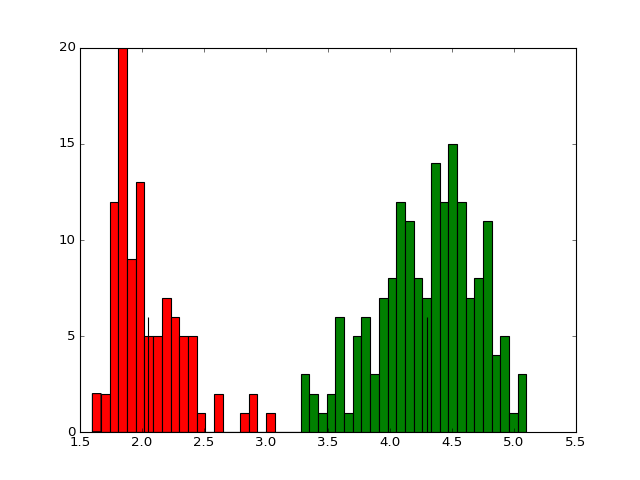

old mus: [ 4.29833908  2.04863265]
new mus: [ 2.04863265  4.29833908]


In [52]:
# The plot will look incorrect until you fix the code above
figure()

mus, clusters = process.next()

x1_range = (x1.min(), x1.max())
hist(x1[clusters==0], bins=50, range=x1_range, color='red')
hist(x1[clusters==1], bins=50, range=x1_range, color='green')
vlines(mus, 0, freqs.max())

# More of the Same Challenge...
If you implemented the code above _just_ right (or if you edit it a bit), then it will work on multidimensional data as well. 
Give it a try:

In [42]:
process = kmeans(column_stack([x1, x2]), 2)

<IPython.core.display.Javascript object>


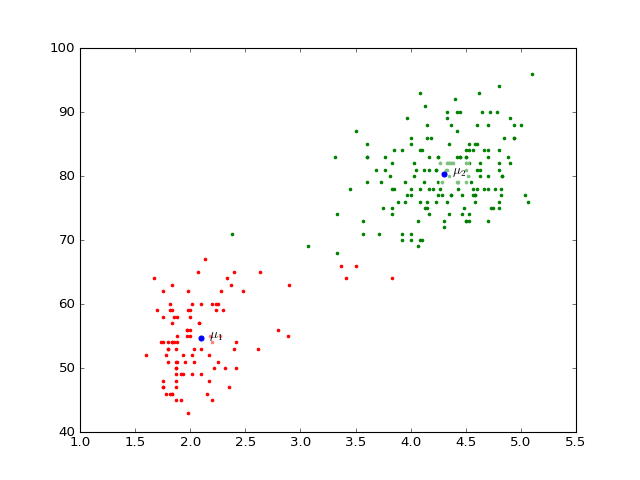

old mus: [[  4.29793023  80.28488372]
 [  2.09433     54.75      ]]
new mus: [[  2.09433     54.75      ]
 [  4.29793023  80.28488372]]


In [46]:
figure()

mus, clusters = process.next()

scatter(x1[clusters==0], x2[clusters==0], color='red', s=5)
scatter(x1[clusters==1], x2[clusters==1], color='green', s=5)
scatter(mus[:,0], mus[:,1], color='blue', zorder=3)
text(mus[0,0], mus[0,1], '  $\mu_1$',  bbox=dict(lw=0, facecolor='white', alpha=0.5), zorder=2)
text(mus[1,0], mus[1,1], '  $\mu_2$',  bbox=dict(lw=0, facecolor='white', alpha=0.5), zorder=2)
show()